Step 0: Dataset Understanding - FaceForensics++

In [1]:
# CELL 1: Import required libraries

import os
import random
import cv2
import matplotlib.pyplot as plt


In [2]:
# CELL 2: Define dataset path 

DATASET_DIR = "/kaggle/input/ff-c23/FaceForensics++_C23"

os.listdir(DATASET_DIR)


['Face2Face',
 'csv',
 'Deepfakes',
 'DeepFakeDetection',
 'original',
 'NeuralTextures',
 'FaceShifter',
 'FaceSwap']

In [3]:
# CELL 3: View top-level hierarchy

for item in os.listdir(DATASET_DIR):
    print(item)


Face2Face
csv
Deepfakes
DeepFakeDetection
original
NeuralTextures
FaceShifter
FaceSwap


In [4]:
# CELL 4: Explore folder hierarchy
for root, dirs, files in os.walk(DATASET_DIR):
    print(f"\n📁 {root}")
    print("   Subfolders:", dirs)
    print("   Files:", files[:5])
    break




📁 /kaggle/input/ff-c23/FaceForensics++_C23
   Subfolders: ['Face2Face', 'csv', 'Deepfakes', 'DeepFakeDetection', 'original', 'NeuralTextures', 'FaceShifter', 'FaceSwap']
   Files: []


In [5]:
# CELL 4: Select only valid video classes and count videos

video_extensions = ('.mp4', '.avi', '.mov', '.mkv')

classes = []
class_counts = {}

for folder in os.listdir(DATASET_DIR):
    folder_path = os.path.join(DATASET_DIR, folder)
    
    if os.path.isdir(folder_path):
        videos = [
            f for f in os.listdir(folder_path)
            if f.lower().endswith(video_extensions)
        ]
        
        if len(videos) > 0:
            classes.append(folder)
            class_counts[folder] = len(videos)

classes, class_counts


(['Face2Face',
  'Deepfakes',
  'DeepFakeDetection',
  'original',
  'NeuralTextures',
  'FaceShifter',
  'FaceSwap'],
 {'Face2Face': 1000,
  'Deepfakes': 1000,
  'DeepFakeDetection': 1000,
  'original': 1000,
  'NeuralTextures': 1000,
  'FaceShifter': 1000,
  'FaceSwap': 1000})

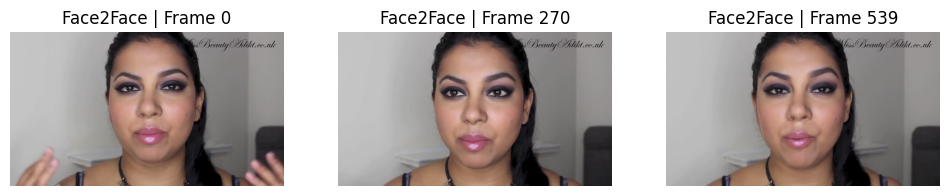

In [6]:
# CELL 5: Display 3 frames from a random video

# Select random class and video
selected_class = random.choice(classes)
video_folder = os.path.join(DATASET_DIR, selected_class)

video_name = random.choice([
    f for f in os.listdir(video_folder)
    if f.lower().endswith(video_extensions)
])

video_path = os.path.join(video_folder, video_name)

# Open video
cap = cv2.VideoCapture(video_path)

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_ids = [0, frame_count // 2, frame_count - 1]

frames = []

for fid in frame_ids:
    cap.set(cv2.CAP_PROP_POS_FRAMES, fid)
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

cap.release()

# Display frames
plt.figure(figsize=(12, 4))
for i, frame in enumerate(frames):
    plt.subplot(1, len(frames), i + 1)
    plt.imshow(frame)
    plt.title(f"{selected_class} | Frame {frame_ids[i]}")
    plt.axis("off")

plt.show()


In [7]:
# CELL 6: Dataset summary

total_videos = sum(class_counts.values())

print("Total classes:", len(classes))
print("Total videos:", total_videos)
print("\nVideos per class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")


Total classes: 7
Total videos: 7000

Videos per class:
Face2Face: 1000
Deepfakes: 1000
DeepFakeDetection: 1000
original: 1000
NeuralTextures: 1000
FaceShifter: 1000
FaceSwap: 1000


Step 1: Data Preprocessing

In [8]:
# CELL 7: Additional libraries for preprocessing

import numpy as np
from tqdm import tqdm

import torch
from torchvision import transforms


In [9]:
# CELL 8: Preprocessing configuration 

NUM_FRAMES = 8              # frames per video
IMG_SIZE = 224              # resize to 224x224
MAX_VIDEOS_PER_CLASS = 5  # limit for faster experimentation (adjust later)

OUTPUT_DIR = "/kaggle/working/preprocessed_frames"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [10]:
# CELL 9: Load face detector

face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

assert not face_cascade.empty(), "❌ Face cascade not loaded"


In [11]:
# CELL 10: Function to extract N uniformly spaced frames

def extract_frames(video_path, num_frames=8):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if total_frames < num_frames:
        cap.release()
        return []
    
    frame_ids = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    frames = []

    for fid in frame_ids:
        cap.set(cv2.CAP_PROP_POS_FRAMES, fid)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)

    cap.release()
    return frames


In [12]:
# CELL 11: Face detection and cropping

def detect_and_crop_face(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(
        gray, scaleFactor=1.3, minNeighbors=5
    )

    if len(faces) == 0:
        return None

    # take largest face
    x, y, w, h = sorted(
        faces, key=lambda b: b[2] * b[3], reverse=True
    )[0]

    face = frame[y:y+h, x:x+w]
    return face


In [13]:
# CELL 12: ImageNet normalization (for ResNet-18)

image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])


In [14]:
# CELL 13: Preprocess dataset (frame extraction + face detection)

for cls in classes:
    cls_input_dir = os.path.join(DATASET_DIR, cls)
    cls_output_dir = os.path.join(OUTPUT_DIR, cls)
    os.makedirs(cls_output_dir, exist_ok=True)

    videos = [
        v for v in os.listdir(cls_input_dir)
        if v.lower().endswith(video_extensions)
    ][:MAX_VIDEOS_PER_CLASS]

    print(f"🔹 Processing class: {cls} | Videos: {len(videos)}")

    for video in tqdm(videos):
        video_path = os.path.join(cls_input_dir, video)
        video_name = os.path.splitext(video)[0]

        out_video_dir = os.path.join(cls_output_dir, video_name)
        os.makedirs(out_video_dir, exist_ok=True)

        frames = extract_frames(video_path, NUM_FRAMES)
        if len(frames) != NUM_FRAMES:
            continue

        saved = 0
        for i, frame in enumerate(frames):
            face = detect_and_crop_face(frame)
            if face is None:
                continue

            face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            tensor = image_transform(face_rgb)

            torch.save(
                tensor, os.path.join(out_video_dir, f"frame_{i}.pt")
            )
            saved += 1

        if saved < NUM_FRAMES:
            # remove incomplete samples
            for f in os.listdir(out_video_dir):
                os.remove(os.path.join(out_video_dir, f))
            os.rmdir(out_video_dir)


🔹 Processing class: Face2Face | Videos: 5


100%|██████████| 5/5 [00:19<00:00,  3.94s/it]


🔹 Processing class: Deepfakes | Videos: 5


100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


🔹 Processing class: DeepFakeDetection | Videos: 5


100%|██████████| 5/5 [00:25<00:00,  5.00s/it]


🔹 Processing class: original | Videos: 5


100%|██████████| 5/5 [00:15<00:00,  3.08s/it]


🔹 Processing class: NeuralTextures | Videos: 5


100%|██████████| 5/5 [00:19<00:00,  3.84s/it]


🔹 Processing class: FaceShifter | Videos: 5


100%|██████████| 5/5 [00:20<00:00,  4.09s/it]


🔹 Processing class: FaceSwap | Videos: 5


100%|██████████| 5/5 [00:19<00:00,  3.85s/it]
